#### Version - 1.0
### Introduction: Methodology

This analysis aims to develop an interpretable and stable model for predicting customer churn in the Telco dataset. The methodology is structured around simplified feature engineering, model building, and a data-driven approach to feature selection.

**Base Hypotheses:**

1.  One-hot encoded features improve model stability.
2.  Selecting the k most linearly correlated features enables effective and stable model construction.

**Methodological Approach:**

1.  **Data Preparation and Feature Engineering:**
    * Load and clean the dataset.
    * One-hot encode categorical features using `pd.get_dummies(drop_first=True)`.
2.  **Optimal 'k' Determination:**
    * Define a range of 'k' values (number of top correlated features) to test.
    * For each 'k', create a model pipeline (feature selection + logistic regression).
    * Evaluate each pipeline using k-fold cross-validation (AUC-ROC or F1-score).
    * Select the 'k' value yielding the best average performance.
3.  **Model Building and Evaluation:**
    * Split the data into training, validation, and test sets.
    * Train a logistic regression model using the selected top-k features (optimal 'k').
    * Evaluate model performance on the test set.
4.  **Hypothesis Verification:**
    * **Hypothesis 1 (One-Hot Encoding Stability):**
        * Assess stability using k-fold cross-validation and coefficient consistency.
    * **Hypothesis 2 (Top-k Correlation Effectiveness):**
        * Verify feature importance through model coefficients.
        * Compare model performance with optimal 'k' to a model using all features.
5.  **Probability Alignment:**
    * Calibrate the model using appropriate techniques to ensure accurate probability estimates.

This methodology prioritizes interpretability, stability, and data-driven feature selection through an A/B testing-like approach for optimal 'k' determination.

### 1. Data Loading and Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r"C:\Users\91807\Desktop\Project\Customer_churn_telco\data\Telco_customer_churn.csv")
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


#### Function: preprocess_telco_data

This function preprocesses the Telco customer churn dataset by performing the following operations:
1. Converting TotalCharges to numeric and handling missing values.
2. Converting SeniorCitizen to boolean.
3. Removing the customerID column.

Justification:
1. TotalCharges: The 'TotalCharges' column was initially loaded as an object
    (string) type, but it represents numerical data. This function converts
    it to a numeric type (float). Missing values in 'TotalCharges' are
    handled by dropping rows where 'tenure' is zero. This is done because
    the missing 'TotalCharges' values correspond to customers with zero
    tenure, suggesting that they have not yet incurred any charges.
    Dropping these rows is a safer approach than imputing values, as it
    avoids introducing potentially incorrect assumptions into the data.

2. SeniorCitizen: The 'SeniorCitizen' column, representing whether a
    customer is a senior citizen, was initially loaded as a numerical type
    (0 or 1). This function converts it to a boolean type (True or False)
    for better semantic clarity and consistency with other boolean columns.

3. customerID: The 'customerID' column is a unique identifier for each
    customer and does not provide any predictive information for churn.
    Therefore, it is removed from the DataFrame to reduce dimensionality
    and improve model performance.


In [ ]:
def preprocess_telco_data_1(df):
    """
    Preprocesses the Telco customer churn dataset by:
    1. Converting TotalCharges to numeric and handling missing values.
    2. Converting SeniorCitizen to boolean.
    3. Removing the customerID column.

    Args:
        df (pd.DataFrame): The raw Telco customer churn dataset.

    Returns:
        pd.DataFrame: The preprocessed DataFrame.
    """

    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors="coerce")
    zero_tenure = df[df['tenure'] == 0].index
    na_total_charges = df[df['TotalCharges'].isnull()].index
    if zero_tenure.equals(na_total_charges): #check the equality before dropping.
        df = df.drop(index=zero_tenure)

    df['SeniorCitizen'] = (df['SeniorCitizen']).astype(bool)
    df = df.drop(columns=['customerID'])

    return df

In [7]:
df_processed = preprocess_telco_data_1(df)
df_processed.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,False,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,False,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,False,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,False,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,False,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### Function: 
- (a) convert_yes_no_to_boolean
- (b) get_yes_no_columns

These functions convert columns with 'Yes'/'No' values to boolean True/False in a Pandas DataFrame.

Justification:
1. Ensures that Yes'es and No's are not one-hot encoded.
2. Converts Object type to boolean

In [ ]:
def convert_yes_no_to_boolean(df, columns):
    """
    Converts 'Yes'/'No' columns to boolean True/False.

    Args:
        df (pd.DataFrame): The DataFrame containing the columns.
        columns (list): A list of column names with 'Yes'/'No' values.

    Returns:
        pd.DataFrame: The DataFrame with converted boolean columns.
    """
    df_converted = df.copy()  # Create a copy to avoid modifying the original

    for col in columns:
        if col in df_converted.columns:
            df_converted[col] = df_converted[col].map({'Yes': True, 'No': False})

    return df_converted


def get_yes_no_columns(df):
    """
    Automatically identifies columns in a DataFrame that contain only 'Yes' and 'No' values.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        list: A list of column names containing only 'Yes' and 'No' values.
    """

    yes_no_cols = []
    for col in df.columns:
        unique_values = df[col].unique()
        if set(unique_values) == {'Yes', 'No'}:
            yes_no_cols.append(col)
    return yes_no_cols


['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']


In [10]:
bool_cols = get_yes_no_columns(df_processed)
df_encoded = convert_yes_no_to_boolean(df_processed, bool_cols)
df_encoded.head(5).T

,0,1,2,3,4
gender,Female,Male,Male,Male,Female
SeniorCitizen,False,False,False,False,False
Partner,True,False,False,False,False
Dependents,False,False,False,False,False
tenure,1,34,2,45,2
PhoneService,False,True,True,False,True
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No
OnlineBackup,Yes,No,Yes,No,No


In [13]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   bool   
 2   Partner           7032 non-null   bool   
 3   Dependents        7032 non-null   bool   
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   bool   
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   bool   
 16  PaymentMethod     7032 non-null   object 
 17  

#### Function: convert_remaining_objects_to_dummies

This function converts the remaining object type columns in a Pandas DataFrame to dummy variables using one-hot encoding.

Justification:
1. Listed in the base hypothesis. 

In [15]:
import pandas as pd

def convert_remaining_objects_to_dummies(df, exclude_columns=None):
    """
    Converts remaining object type columns in a DataFrame to dummy variables
    using one-hot encoding.

    Args:
        df (pd.DataFrame): The input DataFrame.
        exclude_columns (list, optional): A list of column names to exclude from
                                          dummy variable conversion. Defaults to None.

    Returns:
        pd.DataFrame: A new DataFrame with object type columns converted to
                      dummy variables.
    """

    df_dummies = df.copy()  # Create a copy to avoid modifying the original
    object_cols = df_dummies.select_dtypes(include=['object']).columns

    if exclude_columns:
        object_cols = [col for col in object_cols if col not in exclude_columns]

    df_dummies = pd.get_dummies(df_dummies, columns=object_cols, drop_first=True)

    return df_dummies


In [19]:
df_encoded.MultipleLines.value_counts()

MultipleLines
No                  3385
Yes                 2967
No phone service     680
Name: count, dtype: int64

In [16]:
df_with_dummies = convert_remaining_objects_to_dummies(df_encoded, None)
df_with_dummies.head(5).T

,0,1,2,3,4
SeniorCitizen,False,False,False,False,False
Partner,True,False,False,False,False
Dependents,False,False,False,False,False
tenure,1,34,2,45,2
PhoneService,False,True,True,False,True
PaperlessBilling,True,False,True,False,True
MonthlyCharges,29.85,56.95,53.85,42.3,70.7
TotalCharges,29.85,1889.5,108.15,1840.75,151.65
Churn,False,False,True,False,True
gender_Male,False,True,True,True,False


#### Correlation Testing

In [51]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [54]:
corr_matrix = df_encoded.corr()
churn_corr = corr_matrix['Churn']

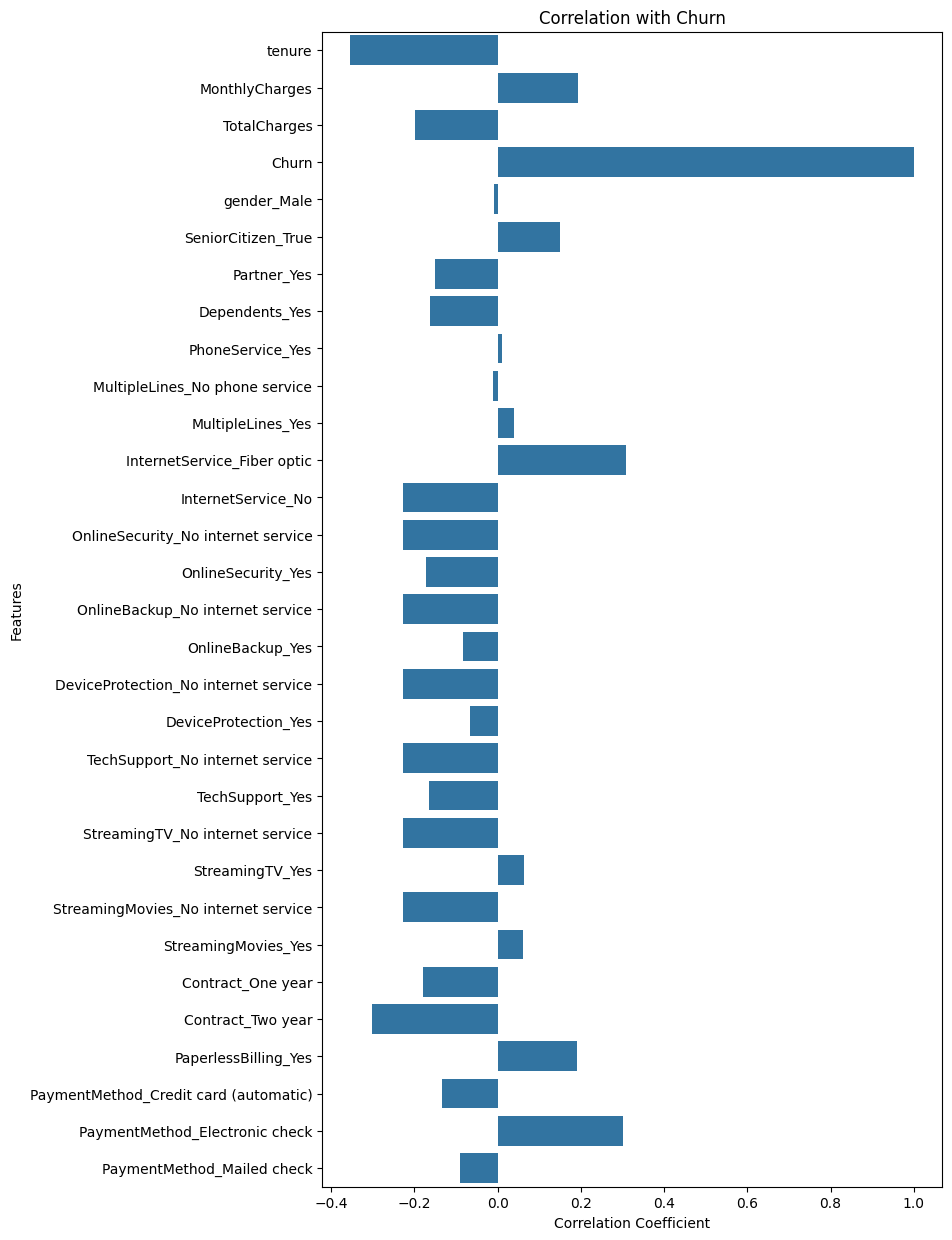

In [59]:
plt.figure(figsize=(8,15))
sns.barplot(x=churn_corr.values, y=churn_corr.index)
plt.title('Correlation with Churn')
plt.ylabel('Features')
plt.xlabel('Correlation Coefficient')
plt.show()
